# 6. Kernel Methods

### *Table of Contents*

* 6.1 [Dual Representations](#6.1-Dual-Representations)
* 6.2 [Constructing Kernels](#6.2-Constructing-Kernels)
* 6.3 [Radial Basis Function Networks](#6.3-Radial-Basis-Function-Networks)
* 6.4 [Gaussian Processes](#6.4-Gaussian-Processes)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from prml.preprocessing import PolynomialFeature, GaussianFeature, SigmoidFeature

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide="ignore", invalid="ignore")

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

In [Chapter 3](ch3_linear_models_for_regression.ipynb) and [4](ch4_linear_models_for_classification.ipynb), we considered linear parametric models governed by a vector $\mathbf{w}$ of adaptive parameters. During the learning phase, a set of training data is used to obtain a point estimate of the parameter vector or determine their posterior distribution. Then, the training set may be discarded and predictions are based only on the learned parameters. The same approach is employed for non-linear models such as neural networks.

However, there is a class of techniques, in which the training data are kept and used also in the prediction phase. For instance, *memory-based* methods, such as Parzen density models and nearest-neighbors, store the entire training set in order to make predictions for future data points. These methods typically require a metric that measures the similarity of any pair of vectors in the input space. They are generally fast to train, because they just store the training data, and slow at making predictions, because they have to pass over the training set, possibly multiple times.

Interestingly, many linear parametric models can be re-cast into an equivalent *dual representation* in which the predictions are also based on linear combinations of a *kernel function* evaluated on the training data points. Assuming models based on a fixed nonlinear *feature space* mapping $\boldsymbol\phi(\mathbf{x})$, the kernel function is defined by

$$
k(\mathbf{x},\mathbf{x}') = \boldsymbol\phi(\mathbf{x})^T\boldsymbol\phi(\mathbf{x}')
$$

where the kernel is a symmetric function of its arguments $k(\mathbf{x},\mathbf{x}')=k(\mathbf{x}',\mathbf{x})$. To that end, the simplest example of a kernel function is obtained by considering the identity feature mapping, which is $\boldsymbol\phi(\mathbf{x})=\mathbf{x}$, and thus $k(\mathbf{x},\mathbf{x}')=\mathbf{x}^T\mathbf{x}'$ is referred as the **linear kernel**.

The concept of a kernel formulated as an inner product in a feature space allows us to build interesting extensions of well-known algorithms by making use of the *kernel trick*, also known as *kernel substitution*. The idea is to replace the scalar product of the input vector $\mathbf{x}$ in the formulation of interest with any kernel.

> One of the most significant developments has been the extension of kernels to handle symbolic objects.

## 6.1 Dual Representations

Consider a linear regression model whose parameters are determined by minimizing the regularized sum-of-squares error function given by

$$
E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)^2 + \frac{\lambda}{2}\mathbf{w}^T\mathbf{w}
$$

If we set the gradient of $E(\mathbf{w})$ with respect to $\mathbf{w}$ equal to zero, then, the solution for $\mathbf{w}$ takes the form of a linear combination of the vectors $\boldsymbol\phi(\mathbf{x}_n)$, with coefficients $a_n$ that are functions of $\mathbf{w}$,

$$
\begin{aligned}
\nabla E(\mathbf{w}) = \mathbf{0} & \Leftrightarrow 
\nabla\frac{1}{2}\sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)^2 + \frac{\lambda}{2}\mathbf{w}^T\mathbf{w} = \mathbf{0} \\
& \Leftrightarrow \sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)\boldsymbol\phi(\mathbf{x}_n) + \lambda\mathbf{w} = \mathbf{0} \\
& \Leftrightarrow \lambda\mathbf{w} = - \sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)\boldsymbol\phi(\mathbf{x}_n) \\
& \Leftrightarrow \mathbf{w} = - \frac{1}{\lambda} \sum_{n=1}^N \big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)\boldsymbol\phi(\mathbf{x}_n) \\
& \Leftrightarrow \mathbf{w} = \sum_{n=1}^N a_n\boldsymbol\phi(\mathbf{x}_n)
\end{aligned}
$$

where $a_n =  -\frac{1}{\lambda}\big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - t_n\big)$. Then, using a ($N\times M$) design matrix $\boldsymbol\Phi$, whose nth row is given by $\boldsymbol\phi(\mathbf{x}_n)^T$, and $a = (a_1,\dots,a_N)^T$, we obtain

$$
\mathbf{w} = \boldsymbol\Phi^T\mathbf{a}
$$

The dual representation is obtained if instead of working with the parameter vector $\mathbf{w}$, we reformulate the least-squares algorithm in terms of the parameter vector $\mathbf{a}$. If we substitute $\mathbf{w} = \boldsymbol\Phi^T\mathbf{a}$ into $E(\mathbf{w})$, we obtain,

$$
\begin{aligned}
E(\mathbf{a}) &= \frac{1}{2}\sum_{n=1}^N \big(\mathbf{a}^T\boldsymbol\Phi\boldsymbol\phi(\mathbf{x}_n) - t_n\big)^2 + \frac{\lambda}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} \\
&= \frac{1}{2} \Big|\Big| \mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T - \mathsf{t} \Big|\Big|_2^2 + \frac{\lambda}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} \\
&= \frac{1}{2} \Big( \mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} - 2\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathsf{t} + \mathsf{t}^T\mathsf{t} \Big) + \frac{\lambda}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} \\
&= \frac{1}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a} - \mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathsf{t} + \frac{1}{2}\mathsf{t}^T\mathsf{t} + \frac{\lambda}{2}\mathbf{a}^T\boldsymbol\Phi\boldsymbol\Phi^T\mathbf{a}
\end{aligned}
$$

By defining the *Gram* matrix $\mathbf{K} = \boldsymbol\Phi\boldsymbol\Phi^T$, which is a symmetric $N \times N$ matrix with elements, $K_{nm} = k(x_n, x_m) = \boldsymbol\phi(x_n)^T\boldsymbol\phi(x_m)$, where $k$ is a kernel function, the sum-of-squares error function can be written as,

$$
E(\mathbf{a}) = \frac{1}{2}\mathbf{a}^T\mathbf{K}\mathbf{K}\mathbf{a} - \mathbf{a}^T\mathbf{K}\mathsf{t} + \frac{1}{2}\mathsf{t}^T\mathsf{t} + \frac{\lambda}{2}\mathbf{a}^T\mathbf{K}\mathbf{a}
$$

If we set the gradient of $E(\mathbf{a})$ equal to zero, then, we obtain the following solution,

$$
\begin{aligned}
\nabla E(\mathbf{a}) = \mathbf{0} & \Leftrightarrow 
\nabla \frac{1}{2}\mathbf{a}^T\mathbf{K}\mathbf{K}\mathbf{a} - \mathbf{a}^T\mathbf{K}\mathsf{t} + \frac{1}{2}\mathsf{t}^T\mathsf{t} + \frac{\lambda}{2}\mathbf{a}^T\mathbf{K}\mathbf{a} = 
\mathbf{0} \\
& \Leftrightarrow \mathbf{K}\mathbf{K}\mathbf{a} - \mathbf{K}\mathsf{t} + \mathbf{K}\mathbf{a} = \mathbf{0} \\
& \Leftrightarrow \mathbf{K}\mathbf{a}(\mathbf{K} + \lambda\mathbf{I}) - \mathbf{K}\mathsf{t} = \mathbf{0} \\
& \Leftrightarrow \mathbf{K}\mathbf{a}(\mathbf{K} + \lambda\mathbf{I}) = \mathbf{K}\mathsf{t} \\
& \Leftrightarrow \mathbf{a}(\mathbf{K} + \lambda\mathbf{I}) = \mathsf{t} \\
& \Leftrightarrow \mathbf{a} = (\mathbf{K} + \lambda\mathbf{I})^{-1}\mathsf{t}
\end{aligned}
$$

By substituting this back into the linear regression model, we obtain,

$$
y(\mathbf{x}) = \mathbf{w}^T\boldsymbol\Phi\boldsymbol\phi(\mathbf{x}) = \mathbf{a}^T\boldsymbol\Phi\boldsymbol\phi(\mathbf{x}) = 
\boldsymbol\Phi\boldsymbol\phi(\mathbf{x})(\mathbf{K} + \lambda\mathbf{I})^{-1}\mathsf{t} = 
\mathbf{k}(\mathbf{x})^T(\mathbf{K} + \lambda\mathbf{I})^{-1}\mathsf{t}
$$

where $\mathbf{k}(\mathbf{x})^T = [k(\mathbf{x}_1, \mathbf{x}),\dots,k(\mathbf{x}_N, \mathbf{x})] = [\boldsymbol\phi(\mathbf{x}_1)^T\boldsymbol\phi(\mathbf{x}),\dots,\boldsymbol\phi(\mathbf{x}_N)^T\boldsymbol\phi(\mathbf{x})]$

Therefore, the dual formulation allows the solution to the least-squares problem to be expressed entirely in terms of a kernel function. 

> **NOTE:** In the dual formulation, we determine the parameter vector a by inverting an $N \times N$ matrix, whereas in the original parameter space formulation, we had to invert an $M \times M$ matrix in order to determine $\mathbf{w}$. Because $N$ is typically much larger than $M$, the dual formulation does not seem to be particularly useful. However, theadvantage of the dual formulation is that it is expressed entirely in terms of the kernel function $k(\mathbf{x}, \mathbf{x}')$. Therefore, we work directly in terms of kernels and avoid the explicit introduction of the feature vector $\boldsymbol\phi(\mathbf{x})$, which allows us to use feature spaces of high, even infinite, dimensionality.

In fact, the existence of a dual representation based on the Gram matrix is a property of many linear models. For instance, let's develop the same representation for the Perceptron algorithm. The update rule for the Perceptron is as follows,

$$
\mathbf{w}^{\tau+1} = \mathbf{w}^{\tau} + \eta\boldsymbol\phi(\mathbf{x}_n)t_n 
$$

Assuming $\mathbf{w}^0 = \mathbf{0}$, then

$$
\begin{aligned}
\mathbf{w}^{(1)} &= \eta\boldsymbol\phi(\mathbf{x}_n)t_n \\
\mathbf{w}^{(2)} &= 2\eta\boldsymbol\phi(\mathbf{x}_n)t_n \\
&\dots \\
\mathbf{w}^{(\tau)} &= \tau\eta\boldsymbol\phi(\mathbf{x}_n)t_n \\
\mathbf{w}^{(\tau+1)} &= (\tau+1)\eta\boldsymbol\phi(\mathbf{x}_n)t_n
\end{aligned}
$$

or

$$
\mathbf{w} = \sum_{n=1}^N \eta c_n t_n \boldsymbol\phi(\mathbf{x}_n) = \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n)
$$

By substituting $\mathbf{w}$ back to the original update formula, we obtain,

$$
\begin{aligned}
\sum_{n=1}^N a_n^{(\tau+1)} t_n \boldsymbol\phi(\mathbf{x}_n) &= \sum_{n=1}^N a_n^{(\tau)} t_n \boldsymbol\phi(\mathbf{x}_n) + \eta t_n \boldsymbol\phi(\mathbf{x}_n) \Leftrightarrow \\
\sum_{n=1}^N a_n^{(\tau+1)} &= \sum_{n=1}^N a_n^{(\tau)} + \eta
\end{aligned}
$$

In other words, the update process is to add learning rate $\eta$ to the coefficient $a_n$, corresponding to input $\mathbf{x}_n$. Finally, substituting back to the linear model, we obtain,

$$
y(\mathbf{x}) = f(\mathbf{w}^T\boldsymbol\phi(\mathbf{x})) = f\Big(\sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n)^T\boldsymbol\phi(\mathbf{x})\Big) = 
f\Big(\sum_{n=1}^N a_n t_n k(\mathbf{x}_n, \mathbf{x})\Big)
$$


## 6.2 Constructing Kernels

One approach is to choose a feature space mapping $\boldsymbol\phi(\mathbf{x})$, e.g., polynomials, gaussian etc, and then use it to find the corresponding kernel.

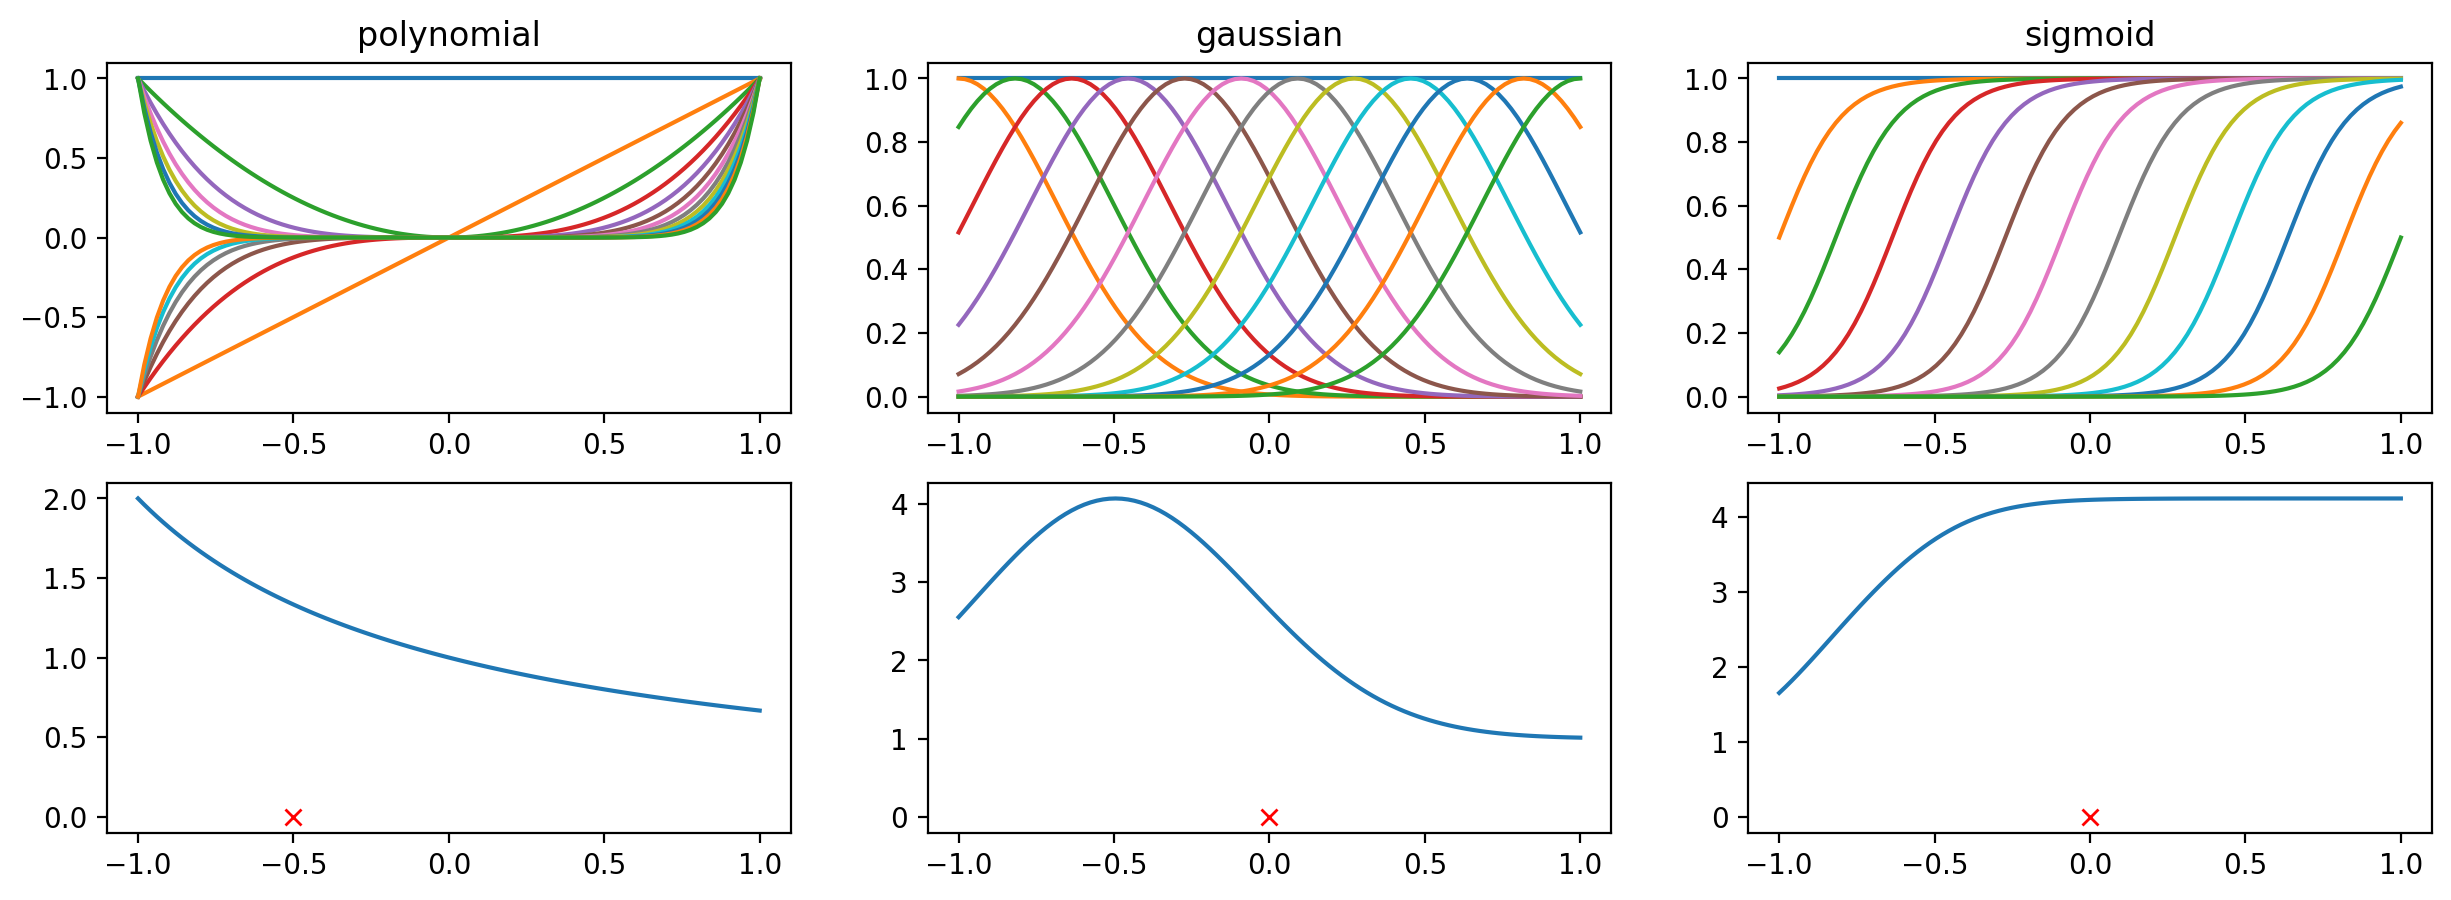

In [45]:
x_space = np.linspace(-1, 1, 100)

# Create 12 degree polynomial basis functions
polynomial = PolynomialFeature(degree=12)

# Create 12 Gaussian basis functions
gaussian = GaussianFeature(mean=np.linspace(-1, 1, 12), sigma=0.1)

# Create 12 sigmoid basis functions
sigmoid = SigmoidFeature(mean=np.linspace(-1, 1, 12), sigma=0.1)

plt.figure(figsize=(15, 5))
for i, phi in enumerate([polynomial, gaussian, sigmoid]):
    x = phi.transform(x_space)
    
    plt.subplot(2, 3, i + 1)
    for j in range(x.shape[1]):
        plt.plot(x_space, x[:, j])
    plt.title(phi.__class__.__name__.removesuffix("Feature").lower())
    
    plt.subplot(2, 3, i + 4)
    plt.plot(0, 0, 'rx') if i > 0 else plt.plot(-0.5, 0, 'rx')
    plt.plot(x_space, x @ phi.transform(-0.5).T)

plt.show()

Another approach is to construct kernel functions directly. In order to exploit kernel substitution, we need to be able to construct valid kernel functions, or in other words kernels that correspond to a scalar product in some (perhaps infinite dimensional) feature space. Consider for instance, a kernel function given by $k(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T\mathbf{z})^2$. Expanding the terms, we can thereby identify the corresponding nonlinear feature mapping,

$$
\begin{aligned}
k(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T\mathbf{z})^2 &= (x_1z_1 + x_2z_2 + \dots + x_Nz_N)^2 \\
&= \sum_{n=1}^N x_n^2z_n^2 + 2\sum_{n=1}^N\sum_{m=1}^{n-1} x_nz_nx_mz_m \\
&= (x_1^2, \sqrt{2}x_1x_2, \dots, x_N^2)(z_1^2, \sqrt{2}z_1z_2, \dots, z_N^2)^T \\
&= \boldsymbol\phi(\mathbf{x})^T\boldsymbol\phi(\mathbf{z})
\end{aligned}
$$

One standard technique for constructing kernels is to build them out of simpler kernels as building blocks. This can be done using the properties $(6.13)$ to $(6.22)$ appearing in the book. In general, the kernel should be symmetric and positive semidefinite and express the appropriate form of similarity between $\mathbf{x}$ and $\mathbf{x}'$.

A commonly used kernel is the Gaussian kernel, which takes the form,

$$
k(\mathbf{x}, \mathbf{z}) = \exp(-||\mathbf{x} - \mathbf{z}||^2 / 2\sigma^2)
$$

> In this context, it is not interpreted as a probability density, and hence the normalization coefficient is omitted.

By expanding the square we obtain,

$$
||\mathbf{x} - \mathbf{z}||^2 = \mathbf{x}^T\mathbf{z} - 2\mathbf{x}^T\mathbf{z} + (\mathbf{z})^T\mathbf{z}
$$

thus,

$$
\exp(-(\mathbf{x}^T\mathbf{x} - 2\mathbf{x}^T\mathbf{z} + (\mathbf{z})^T\mathbf{z}) / 2\sigma^2) = 
\exp(-\mathbf{x}^T\mathbf{x} / 2\sigma^2) + \exp(\mathbf{x}^T\mathbf{z} / \sigma^2) + \exp(-\mathbf{z}^T\mathbf{z} / 2\sigma^2)
$$

which is a valid kernel due to $(6.14)$ and $(6.16)$ and the fact that the linear kernel is valid. Note that the Gaussian kernel is not restricted to Euclidean distance. If we use
kernel substitution to replace $\mathbf{x}^T\mathbf{z}$ with a nonlinear kernel $\kappa(\mathbf{x}, \mathbf{z})$, we obtain

$$
k(\mathbf{x}, \mathbf{z}) = \exp\Big(-\frac{1}{2\sigma^2}\big(\kappa(\mathbf{x},\mathbf{x}) - 2\kappa(\mathbf{x},\mathbf{z}) + \kappa(\mathbf{z},\mathbf{z})\big)\Big) = 
$$

Kernel functions may also be defined over generic objects, as diverse as graphs, sets, strings, and text documents. Consider, for instance, a set and define a non-vectorial space consisting of all possible subsets. If $A_1$ and $A_2$ are two such subsets, then one simple choice of kernel would be,

$$
k(A_1, A_2) = 2^{|A_1 \cap A_1|}
$$

## 6.3 Radial Basis Function Networks

Radial basis functions have the property that each basis function depends only on the radial distance (typically Euclidean) from a centre $\boldsymbol\mu_j$, so that $\boldsymbol\phi_j(\mathbf{x}) = h(||\mathbf{x} - \boldsymbol\mu_j||)$. Historically, radial basis functions were introduced for the purpose of exact function interpolation, which is achieved by expressing $f(\mathbf{x})$ as a linear combination of radial basis functions, one centred on every data point. Then, the parameters $\mathbf{w}$ are found by least squares, and because there are the same number of parameters as there are constraints (data points), the resulted function fits every target value exactly. In machine learning applications, however, the target values are generally noisy, and exact interpolation is undesirable (over-fitting). Moreover, because there is one basis function associated with every data point, the corresponding model can be computationally costly to evaluate when making predictions for new data points.

> One way of choosing the basis function centres is to randomly chose a subset of the data points. A more systematic approach is to use orthogonal least squares, a sequential selection process, in which, at each step the next data point to be chosen as a basis function centre corresponds to the one that gives the greatest reduction in the sum-of-squares error. Clustering algorithms such as $k$-means have also been used, which give a set of basis function centres that no longer coincide with training data points.

## 6.4 Gaussian Processes